In [1]:
#Installing the required Python libraries
!pip install pandas nltk textblob transformers torch

  Using cached textblob-0.18.0.post0-py3-none-any.whl.metadata (4.5 kB)
  Using cached transformers-4.46.2-py3-none-any.whl.metadata (44 kB)
  Using cached torch-2.5.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.4.5-cp312-none-win_amd64.whl.metadata (3.9 kB)
  Using cached tokenizers-0.20.3-cp312-none-win_amd64.whl.metadata (6.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)
Using cached transformers-4.46.2-py3-none-any.whl (10.0 MB)
Using cached torch-2.5.1-cp312-cp312-win_amd64.whl (203.0 MB)
Using cached huggingface_hub-0.26.2-py3-none-any.whl (447 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
Using cached safetensors-0.4.5-cp312-none-win_amd64.whl (286 kB)
Us

In [1]:
import pandas as pd

In [2]:
# Load the dataset- a CSV file - with a 'Lemmatized_Comments' column
df = pd.read_csv(r'C:\Users\paris\OneDrive\thesis\collect data\Analysis\data processing\Cleaned_TikTok_comments3.csv')[['Lemmatized_Comments']]

In [9]:
# Split each entry in the 'Lemmatized_Comments' column into lists of words
df['Lemmatized_Comments'] = df['Lemmatized_Comments'].apply(lambda x: x.split() if isinstance(x, str) else x)

# Verify that each document is now a list of tokens
print(df['Lemmatized_Comments'].iloc[0])
print(type(df['Lemmatized_Comments'].iloc[0]))

['jojoba', 'oil', 'instead', 'olive', 'oil', 'jojoba', 'mean', 'cleanse', 'pore', 'wont', 'clog', 'skin']
<class 'list'>


In [10]:
# 1- Emotion Lexicon Analysis
#Use the NRC Emotion Lexicon for detecting emotions in the comments
from nltk.corpus import wordnet
from collections import defaultdict
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
#Updated Code to Handle Encoding
# Specify the file path
nrc_file_path = 'D:/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'

# Load NRC Emotion Lexicon with the correct encoding
emotion_dict = defaultdict(list)
try:
    with open(nrc_file_path, 'r', encoding='utf-8') as f:  # Try utf-8 first
        for line in f:
            word, emotion, presence = line.strip().split('\t')
            if int(presence) == 1:
                emotion_dict[word].append(emotion)
except UnicodeDecodeError:
    with open(nrc_file_path, 'r', encoding='latin-1') as f:  # Fall back to latin-1
        for line in f:
            word, emotion, presence = line.strip().split('\t')
            if int(presence) == 1:
                emotion_dict[word].append(emotion)

In [13]:
# Analyze emotions in each comment
def get_emotions(Lemmatized_Comments):
    emotions = []
    for token in Lemmatized_Comments:
        token_emotions = emotion_dict.get(token.lower(), [])
        emotions.extend(token_emotions)
    return emotions

df['lexicon_emotions'] = df['Lemmatized_Comments'].apply(get_emotions)


In [14]:
# Summarize emotions
df['lexicon_emotions_summary'] = df['lexicon_emotions'].apply(lambda x: {emotion: x.count(emotion) for emotion in set(x)})

In [15]:
# Mapping NRC emotions to custom categories
emotion_mapping = {
    'joy': 'Joyful',
    'surprise': 'Joyful',
    'trust': 'Trust',
    'positive': 'Joyful',
    'gratitude': 'Trust',
    'negative': 'Anger',  # Map all negative to anger
    'sadness': 'Disappointment',  # Sadness becomes disappointed
    'anger': 'Anger',
    'fear': 'Disappointment',  # Fear becomes worried
    'anticipation': 'Neutral',  # Skeptical as anticipation
    'disgust': 'Anger',  # Map disgust to anger
    'neutral' : 'Neutral',
    'curiosity' : 'Content'
    
}

In [16]:
#Apply Mapping Only to Existing Emotions
# Function to map emotions based on the dictionary
def map_emotions(emotion_list, mapping):
    if not emotion_list:  # If no emotions detected, return as is
        return emotion_list
    return [mapping.get(emotion, emotion) for emotion in emotion_list] 

In [17]:
# Apply the mapping
df['mapped_emotions'] = df['lexicon_emotions_summary'].apply(lambda x: map_emotions(x, emotion_mapping))

# Display the results
print(df[['Lemmatized_Comments', 'lexicon_emotions_summary', 'mapped_emotions']])

                                    Lemmatized_Comments  \
0     [jojoba, oil, instead, olive, oil, jojoba, mea...   
1                             [throw, washer, after, ?]   
2     [magic, makeup, eraser, towel, last, year, nee...   
3                               [makeup, eraser, cloth]   
4     [esthetician, try, almond, oil, jojoba, oil, i...   
...                                                 ...   
2254                                        [love, elf]   
2255                                       [thank, yes]   
2256                                         [pacifica]   
2257  [elf, concealer, forever, chemical, stay, away...   
2258             [could, please, share, alternative, ?]   

                               lexicon_emotions_summary  \
0                    {'positive': 1, 'anticipation': 1}   
1                                                    {}   
2                                                    {}   
3                                                    {}

In [18]:
# Function to combine mapped emotions and question type with specific conditions
def combine_emotions_and_questions(row):
    # Only consider question_type if it's 'Curiosity' or 'Anticipation'
    if row['question_type'] in ['Trust', 'Content']:
        # Include mapped emotions if present
        if row['mapped_emotions']:
            return f" {', '.join(row['mapped_emotions'])} , {row['question_type']}"
        else:
            return row['question_type']
    # If question_type is not 'Curiosity' or 'Anticipation', only include mapped emotions
    elif row['mapped_emotions']:
        return f" {', '.join(row['mapped_emotions'])}"
    # If neither condition is met, return a default message
    else:
        return {}

In [21]:
# Function to normalize the column
def normalize_to_list(value):
    if isinstance(value, str):  # If value is a string, split it into a list
        return [item.strip() for item in value.split(',')]
    elif isinstance(value, dict):  # If value is a dictionary, extract the keys (or values if needed)
        return list(value.keys())
    else:  # If value is neither, return an empty list
        return []



In [22]:
# Function to remove duplicates, normalize case, and trim whitespace
# Deduplication function
def remove_duplicates(emotions):
    if isinstance(emotions, list):
        return list(dict.fromkeys(emotions))  # Remove duplicates while preserving order
    return emotions


In [23]:
# Save emotion summaries to a CSV file
df.to_csv(r'C:\Users\paris\OneDrive\thesis\collect data\lexicon_emotions_TikTok27_test.csv', index=False)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the frequency of each emotion in the 'NRC_analysis' column
emotion_counts = df['mapped_emotions'].explode().value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']

# Creating the visualization
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Count', y='Emotion', data=emotion_counts, palette='viridis')

# Removing unnecessary elements for a cleaner look
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Emotion', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot to a file
plt.savefig('nrc_emotion_analysis_plot_tiktok.png')
plt.close()  # Close the plot display to save memory

# Display a success message
print("Bar chart for NRC analysis saved successfully as 'nrc_emotion_analysis_plot.png'.")


C:\Users\paris\AppData\Local\Temp\ipykernel_12792\2242504903.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Count', y='Emotion', data=emotion_counts, palette='viridis')


Bar chart for NRC analysis saved successfully as 'nrc_emotion_analysis_plot.png'.


In [26]:
# 2- Emotion Analysis: Pre-trained Model Analysis

#Use a pre-trained transformer model (DistilBERT-based model) from the Hugging Face Transformers library:

from transformers import pipeline

# Load a pre-trained emotion classification model
emotion_pipeline = pipeline('text-classification', model='bhadresh-savani/distilbert-base-uncased-emotion')

# Apply model to each comment
df['model_emotions'] = df['Lemmatized_Comments'].apply(lambda x: emotion_pipeline(x))

In [27]:
# Check the type of data in model_emotions
print(df['model_emotions'].apply(type).value_counts())

model_emotions
<class 'list'>    2259
Name: count, dtype: int64


In [28]:
# Mapping for renaming emotions
emotion_rename_mapping = {
    'joy': 'Joyful',  # Map joy to Joyful
    'surprise': 'Joyful', # Map surprise to Joyful
    'trust': 'Trust',
    'positive': 'Joyful', # Map all positive to Joyful
    'gratitude': 'Trust', # Map gratitude to Trust
    'negative': 'Anger',  # Map all negative to Anger
    'sadness': 'Disappointment',  # Sadness becomes Disappointment
    'anger': 'Anger',
    'fear': 'Disappointment',  # Fear becomes Disappointment
    'anticipation': 'Neutral',  # Map anticipation to Neutral
    'disgust': 'Anger',  # Map disgust to anger
    'neutral' : 'Neutral',
    'love': 'Trust' # Map love to Trust   
}

# Function to rename and aggregate emotions
def rename_and_aggregate_emotions(emotion_list):
    if isinstance(emotion_list, list):
        renamed_emotions = {}
        for emotion_dict in emotion_list:
            if isinstance(emotion_dict, dict) and "label" in emotion_dict and "score" in emotion_dict:
                # Rename emotion based on mapping
                new_emotion = emotion_rename_mapping.get(emotion_dict["label"], emotion_dict["label"])
                # Aggregate scores for renamed emotions
                renamed_emotions[new_emotion] = renamed_emotions.get(new_emotion, 0) + emotion_dict["score"]
        return renamed_emotions
    return {}

# Apply the function to the column
df['renamed_emotions'] = df['model_emotions'].apply(rename_and_aggregate_emotions)

# Display the updated DataFrame
print(df[['model_emotions', 'renamed_emotions']])

                                         model_emotions  \
0     [{'label': 'joy', 'score': 0.4655363857746124}...   
1     [{'label': 'anger', 'score': 0.545544445514679...   
2     [{'label': 'joy', 'score': 0.6289324164390564}...   
3     [{'label': 'anger', 'score': 0.414993673563003...   
4     [{'label': 'fear', 'score': 0.3881051242351532...   
...                                                 ...   
2254  [{'label': 'love', 'score': 0.9171563982963562...   
2255  [{'label': 'joy', 'score': 0.978950560092926},...   
2256    [{'label': 'anger', 'score': 0.36312136054039}]   
2257  [{'label': 'anger', 'score': 0.609913825988769...   
2258  [{'label': 'fear', 'score': 0.3235937356948852...   

                                       renamed_emotions  
0     {'Joyful': 4.088815867900848, 'Anger': 3.51342...  
1     {'Anger': 1.7920793890953064, 'Joyful': 0.2714...  
2     {'Joyful': 1.2021642923355103, 'Anger': 3.1098...  
3                         {'Anger': 1.5316428244113922}  
4

In [29]:
print(df['Lemmatized_Comments'].apply(type).value_counts())  # Should mostly be <class 'str'>
print(df['renamed_emotions'].apply(type).value_counts())  

Lemmatized_Comments
<class 'list'>    2259
Name: count, dtype: int64
renamed_emotions
<class 'dict'>    2259
Name: count, dtype: int64


In [36]:
# Save emotion summaries to a CSV file
df.to_csv(r'C:\Users\paris\OneDrive\thesis\collect data\Pre-trained Model Analysis_tiktok26_test.csv', index=False)

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the frequency of each emotion in the 'DistilBERT_emotion_labels' column
emotion_counts = df['renamed_emotions'].explode().value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']

# Creating the visualization
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Count', y='Emotion', data=emotion_counts, palette='viridis')

# Removing unnecessary elements for a cleaner look
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Emotion', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot to a file
plt.savefig('distilbert_emotion_labels_plot_tiktok.png')
plt.close()  # Close the plot display to save memory

# Display a success message
print("Bar chart for DistilBERT emotion labels saved successfully as 'distilbert_emotion_labels_plot.png'.")


C:\Users\paris\AppData\Local\Temp\ipykernel_12792\3840227168.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Count', y='Emotion', data=emotion_counts, palette='viridis')


Bar chart for DistilBERT emotion labels saved successfully as 'distilbert_emotion_labels_plot.png'.


In [37]:
# 3- Emotion Analysis with RoBERTa

# Load the RoBERTa-based emotion classification model
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)



C:\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [38]:
# Function to analyze emotions using the RoBERTa model
def analyze_emotions(Lemmatized_Comments):
    try:
        # Get the model's emotion predictions
        results = emotion_pipeline(Lemmatized_Comments)
        # Extract emotions and scores
        emotion_scores = {result['label']: result['score'] for result in results[0]}
        return emotion_scores
    except Exception as e:
        print(f"Error processing comment: {Lemmatized_Comments}")
        return {}


In [39]:
# Apply emotion analysis to each comment
df['emotion_scores'] = df['Lemmatized_Comments'].apply(analyze_emotions)

In [40]:
# Define the mapping for renaming emotions
emotion_rename_mapping = {
    'joy': 'Joyful', # Map joy to Joyful
    'surprise': 'Joyful', # Map surprise to Joyful
    'trust': 'Trust',
    'positive': 'Joyful', # Map posistive to Joyful
    'gratitude': 'Trust', # Map gratitude to Trust
    'negative': 'Anger',  # Map all negative to Anger
    'sadness': 'Disappointment',  # Sadness becomes Disappointment
    'anger': 'Anger',
    'fear': 'Disappointment',  # Fear becomes Disappointment
    'anticipation': 'Neutral',  # anticipation as Neutral
    'disgust': 'Anger',  # Map disgust to Anger
    'neutral' : 'Neutral', 
    'love': 'Trust', # Map love to Trust
    
}

# Function to rename emotions
def rename_emotions3(emotion_scores):
    if isinstance(emotion_scores, dict):  # Ensure input is a dictionary
        renamed_scores = {}
        for emotion, score in emotion_scores.items():
            # Map the emotion to the new name using the mapping
            renamed_emotion3 = emotion_rename_mapping.get(emotion, emotion)  # Default to the original emotion if not in mapping
            renamed_scores[renamed_emotion3] = renamed_scores.get(renamed_emotion3, 0) + score
        return renamed_scores
    return {}

# Apply the renaming function
df['renamed_emotions3'] = df['emotion_scores'].apply(rename_emotions3)

# Display the updated DataFrame
print(df[['emotion_scores', 'renamed_emotions3']].head())

                                      emotion_scores  \
0  {'anger': 0.0023008217103779316, 'disgust': 0....   
1  {'anger': 0.9274728298187256, 'disgust': 0.007...   
2  {'anger': 0.029301241040229797, 'disgust': 0.0...   
3  {'anger': 0.006257856730371714, 'disgust': 0.0...   
4  {'anger': 0.022525368258357048, 'disgust': 0.1...   

                                   renamed_emotions3  
0  {'Anger': 0.004296369384974241, 'Disappointmen...  
1  {'Anger': 0.9347901050932705, 'Disappointment'...  
2  {'Anger': 0.045414065942168236, 'Disappointmen...  
3  {'Anger': 0.016241840552538633, 'Disappointmen...  
4  {'Anger': 0.127241937443614, 'Disappointment':...  


In [41]:
# Extract dominant emotions with a threshold condition
def get_dominant_emotions_with_threshold(renamed_emotions3, threshold=0.1):
    if not renamed_emotions3 or not isinstance(renamed_emotions3, dict):
        return "unknown"
    # Filter emotions with scores greater than the threshold
    RoBERTa_emotion = [emotion for emotion, score in renamed_emotions3.items() if score > threshold]
    # If no emotion meets the threshold, return "unknown"
    return RoBERTa_emotion if RoBERTa_emotion else "unknown"

# Apply the function to extract dominant emotions
df['RoBERTa_emotion'] = df['renamed_emotions3'].apply(get_dominant_emotions_with_threshold)

# Display results
print(df[['Lemmatized_Comments', 'renamed_emotions3', 'RoBERTa_emotion']].head())


                                 Lemmatized_Comments  \
0  [jojoba, oil, instead, olive, oil, jojoba, mea...   
1                          [throw, washer, after, ?]   
2  [magic, makeup, eraser, towel, last, year, nee...   
3                            [makeup, eraser, cloth]   
4  [esthetician, try, almond, oil, jojoba, oil, i...   

                                   renamed_emotions3  \
0  {'Anger': 0.004296369384974241, 'Disappointmen...   
1  {'Anger': 0.9347901050932705, 'Disappointment'...   
2  {'Anger': 0.045414065942168236, 'Disappointmen...   
3  {'Anger': 0.016241840552538633, 'Disappointmen...   
4  {'Anger': 0.127241937443614, 'Disappointment':...   

                    RoBERTa_emotion  
0                 [Joyful, Neutral]  
1                           [Anger]  
2                 [Joyful, Neutral]  
3                         [Neutral]  
4  [Anger, Disappointment, Neutral]  


In [42]:
# Load the RoBERTa-based sentiment classification model
sentiment_pipeline = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment", return_all_scores=True)

# Define the mapping from model labels to sentiment categories
label_mapping = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

# Function to detect polarity with label mapping
def detect_polarity(comment):
    try:
        # Get sentiment predictions
        results = sentiment_pipeline(comment)
        # Map the labels to sentiment categories
        sentiment_scores = {label_mapping[result['label']]: result['score'] for result in results[0]}
        return sentiment_scores
    except Exception as e:
        print(f"Error processing comment: {comment}")
        return {}

# Apply the sentiment analysis to the DataFrame
df['polarity_scores'] = df['Lemmatized_Comments'].apply(detect_polarity)

C:\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [43]:
# Function to get the dominant polarity
def get_dominant_polarity(polarity_scores):
    if isinstance(polarity_scores, dict) and polarity_scores:
        return max(polarity_scores, key=polarity_scores.get)  # Get the key with the highest score
    return "unknown"

# Apply the function to get the dominant polarity
df['RoBERTa_polarity'] = df['polarity_scores'].apply(get_dominant_polarity)

# Display the updated DataFrame
print(df[['Lemmatized_Comments', 'polarity_scores', 'RoBERTa_polarity']].head())

                                 Lemmatized_Comments  \
0  [jojoba, oil, instead, olive, oil, jojoba, mea...   
1                          [throw, washer, after, ?]   
2  [magic, makeup, eraser, towel, last, year, nee...   
3                            [makeup, eraser, cloth]   
4  [esthetician, try, almond, oil, jojoba, oil, i...   

                                     polarity_scores RoBERTa_polarity  
0  {'negative': 0.18060682713985443, 'neutral': 0...          neutral  
1  {'negative': 0.25526443123817444, 'neutral': 0...          neutral  
2  {'negative': 0.09307744354009628, 'neutral': 0...          neutral  
3  {'negative': 0.17437411844730377, 'neutral': 0...          neutral  
4  {'negative': 0.2538180947303772, 'neutral': 0....          neutral  


In [44]:
df.to_csv(r'C:\Users\paris\OneDrive\thesis\collect data\Roberta_Emotion_Analysis_tiktok26.csv', index=False)

In [45]:

# Count the frequency of each emotion in the 'RoBERTa_emotion' column
emotion_counts = df['RoBERTa_emotion'].explode().value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']

# Creating the visualization
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Count', y='Emotion', data=emotion_counts, palette='viridis')

# Removing unnecessary elements for a cleaner look
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Emotion', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot to a file
plt.savefig('roberta_emotion_analysis_plot.png')
plt.close()  # Close the plot display to save memory

# Display a success message
print("Bar chart for RoBERTa emotion analysis saved successfully as 'roberta_emotion_analysis_plot.png'.")


C:\Users\paris\AppData\Local\Temp\ipykernel_9984\571297182.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Count', y='Emotion', data=emotion_counts, palette='viridis')


Bar chart for RoBERTa emotion analysis saved successfully as 'roberta_emotion_analysis_plot.png'.


In [46]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create a PDF for the Polarity Histogram
with PdfPages('roberta_polarity_histogram.pdf') as pdf:
    plt.figure(figsize=(8, 6))  # Adjusted figure size
    df['RoBERTa_polarity'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
    plt.xlabel('Polarity')
    plt.ylabel('Frequency')
    plt.grid(True)  # Added grid for better readability
    plt.tight_layout()
    pdf.savefig()  # Save the figure into the pdf
    plt.close()  # Close the figure

# Create a PDF for the Sentiment Category Bar Chart
with PdfPages('roberta_sentiment_category_bar_chart.pdf') as pdf:
    plt.figure(figsize=(8, 6))  # Adjusted figure size
    df['RoBERTa_polarity'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'], edgecolor='black')  # Added edge color
    plt.xlabel('Polarity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.grid(axis='y')  # Added grid on the y-axis
    pdf.savefig()  # Save the figure into the pdf
    plt.close()  # Close the figure

print("Two PDF files have been created with enhanced clarity: 'roberta_polarity_histogram.pdf' and 'roberta_sentiment_category_bar_chart.pdf'.")


Two PDF files have been created with enhanced clarity: 'roberta_polarity_histogram.pdf' and 'roberta_sentiment_category_bar_chart.pdf'.


In [47]:
# Aggregate emotion counts for NRC Emotion Lexicon
from collections import Counter

# Aggregate NRC Emotion Counts
nrc_emotion_counts = Counter()
for emotions in df['NRC_analysis']:
    nrc_emotion_counts.update(emotions)

# Convert Counter to pandas Series for visualization
nrc_emotion_counts = pd.Series(nrc_emotion_counts)

print("NRC Emotion Counts:")
print(nrc_emotion_counts)

NRC Emotion Counts:
Neutral            524
Joyful            1207
Trust              829
Anger              622
Disappointment     567
Content             47
dtype: int64


In [48]:
# Aggregate DistilBERT Emotion Counts
Dbert_emotion_counts = df['DistilBERT_emotion_labels'].value_counts()
Dbert_emotion_counts = pd.Series(Dbert_emotion_counts)

print("DBERT Emotion Counts:")
print(Dbert_emotion_counts)

DBERT Emotion Counts:
DistilBERT_emotion_labels
{Joyful}                                    682
{Disappointment, Joyful}                    405
{Joyful, Trust}                             291
{Anger}                                     186
{Disappointment, Joyful, Trust}             176
{Content, Joyful, Trust}                    171
{Disappointment, Joyful, Trust, Content}    139
{Disappointment, Anger}                      73
{Content, Trust}                             45
{Disappointment, Trust, Content}             36
{Trust}                                      25
{Disappointment, Trust}                      10
{Disappointment}                             10
{Disappointment, Joyful, Content}             5
{Content, Joyful}                             3
{Content, Anger}                              2
Name: count, dtype: int64


In [49]:
print("NRC Emotion Counts:")
print(nrc_emotion_counts)

print("\nDistilBERT Emotion Counts:")
print(Dbert_emotion_counts)

NRC Emotion Counts:
Neutral            524
Joyful            1207
Trust              829
Anger              622
Disappointment     567
Content             47
dtype: int64

DistilBERT Emotion Counts:
DistilBERT_emotion_labels
{Joyful}                                    682
{Disappointment, Joyful}                    405
{Joyful, Trust}                             291
{Anger}                                     186
{Disappointment, Joyful, Trust}             176
{Content, Joyful, Trust}                    171
{Disappointment, Joyful, Trust, Content}    139
{Disappointment, Anger}                      73
{Content, Trust}                             45
{Disappointment, Trust, Content}             36
{Trust}                                      25
{Disappointment, Trust}                      10
{Disappointment}                             10
{Disappointment, Joyful, Content}             5
{Content, Joyful}                             3
{Content, Anger}                              2
Name: c

In [50]:
# Convert keys to strings in nrc_emotion_counts
nrc_emotion_counts = {str(k): v for k, v in nrc_emotion_counts.items()}

# Convert keys to strings in bert_emotion_counts
Dbert_emotion_counts = {str(k): v for k, v in Dbert_emotion_counts.items()}

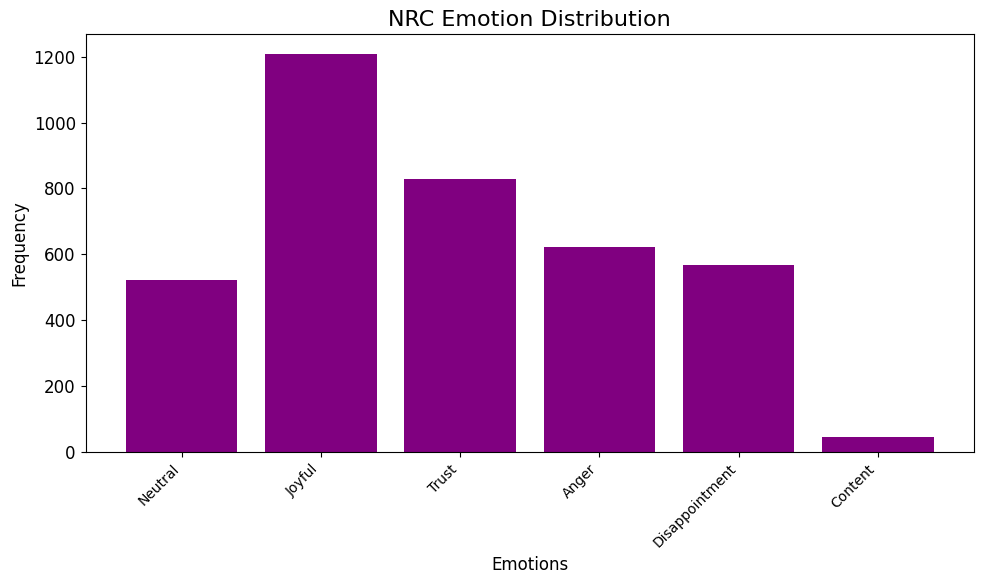

In [51]:
# Set larger font sizes for all plot elements
plt.rcParams.update({'font.size': 12})

# Convert to pandas Series
nrc_emotion_counts = pd.Series(nrc_emotion_counts)
Dbert_emotion_counts = pd.Series(Dbert_emotion_counts)

# Plot NRC Emotion Lexicon

# Flatten the `deduplicated_analysis` column to aggregate all emotions
all_emotions = [emotion for emotions in df['NRC_analysis'] for emotion in emotions]
emotion_counts = Counter(all_emotions)

# Prepare data for the bar chart
emotions, counts = zip(*emotion_counts.items())
# Create the bar chart
plt.figure(figsize=(10, 6))
#nrc_emotion_counts.sort_values().plot(kind='bar', color='skyblue')
plt.bar(emotions, counts, color='purple')
plt.title('NRC Emotion Distribution', fontsize=16)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
plt.tight_layout()
plt.show()




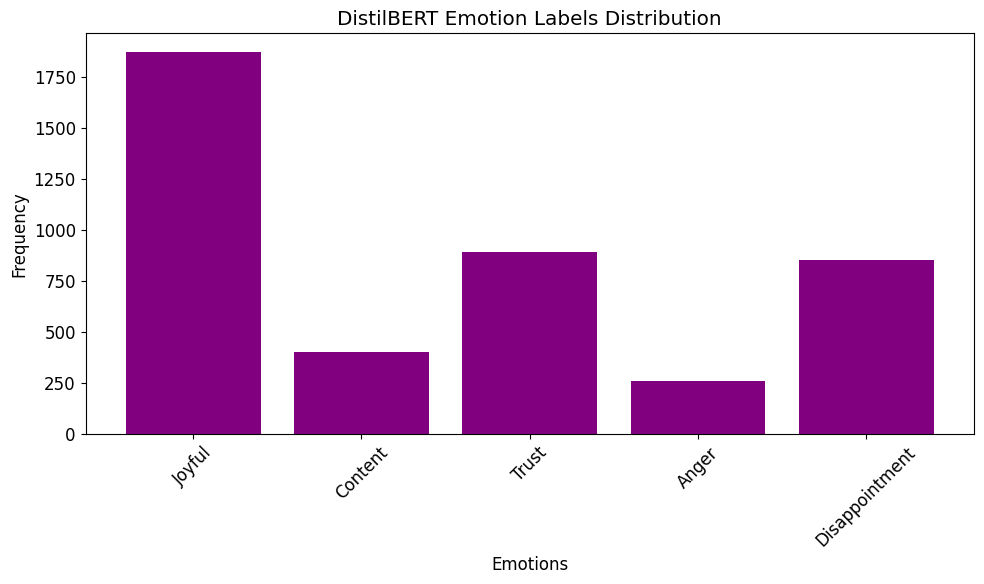

In [52]:
#for DistilBERT
# Flatten the `emotion_labels` column and count the occurrences of each emotion
all_emotions = [emotion for emotions in df['DistilBERT_emotion_labels'] for emotion in emotions]
emotion_counts = Counter(all_emotions)

# Convert to lists for plotting
emotions, counts = zip(*emotion_counts.items())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color='purple')
plt.title('DistilBERT Emotion Labels Distribution')
plt.ylabel('Frequency')
plt.xlabel('Emotions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


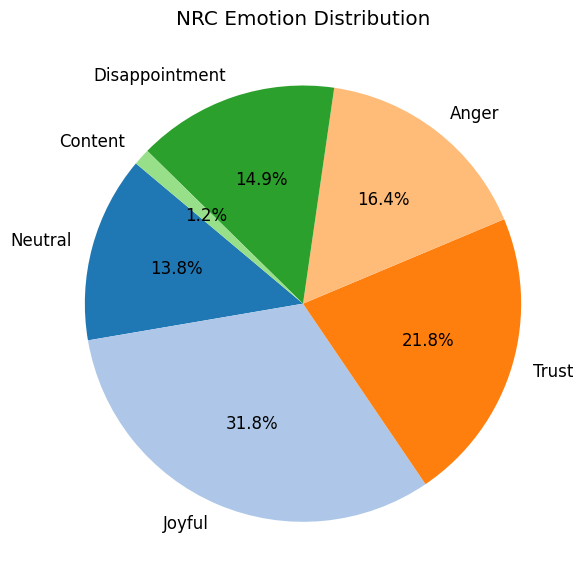

In [53]:
# Flatten the `deduplicated_analysis` column to aggregate all emotions
all_emotions = [emotion for emotions in df['NRC_analysis'] for emotion in emotions]
emotion_counts = Counter(all_emotions)

# Prepare data for the pie chart
emotions, counts = zip(*emotion_counts.items())

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=emotions, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('NRC Emotion Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

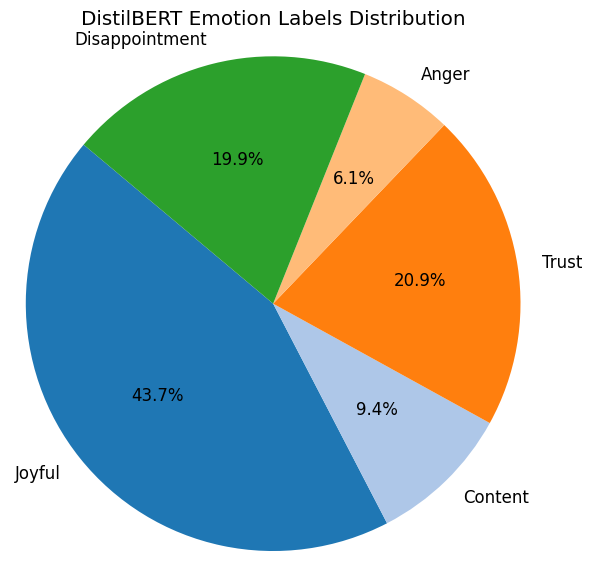

In [54]:
# Plot pie chart for DistilBERT

# Flatten the `deduplicated_analysis` column to aggregate all emotions
all_emotions = [emotion for emotions in df['DistilBERT_emotion_labels'] for emotion in emotions]
emotion_counts = Counter(all_emotions)

# Prepare data for the pie chart
emotions, counts = zip(*emotion_counts.items())


plt.figure(figsize=(6, 6))
plt.pie(counts, labels=emotions, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('DistilBERT Emotion Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [55]:
!pip install wordcloud

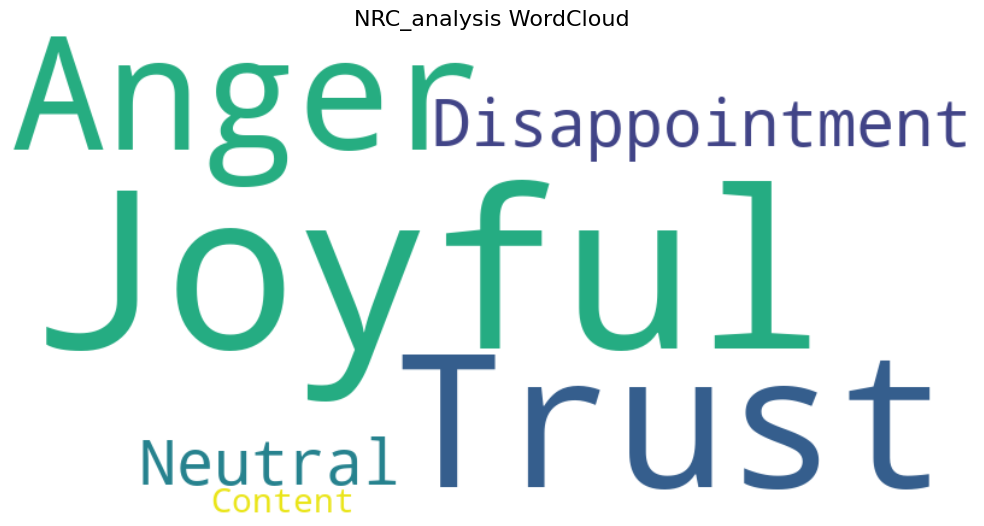

In [56]:
from wordcloud import WordCloud


# Generate word cloud for NRC
# Flatten the `deduplicated_analysis` column to aggregate all emotions
all_emotions = [emotion for emotions in df['NRC_analysis'] for emotion in emotions]
emotion_counts = Counter(all_emotions)

# Generate the WordCloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis'
).generate_from_frequencies(emotion_counts)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('NRC_analysis WordCloud', fontsize=16)
plt.tight_layout()
plt.show()


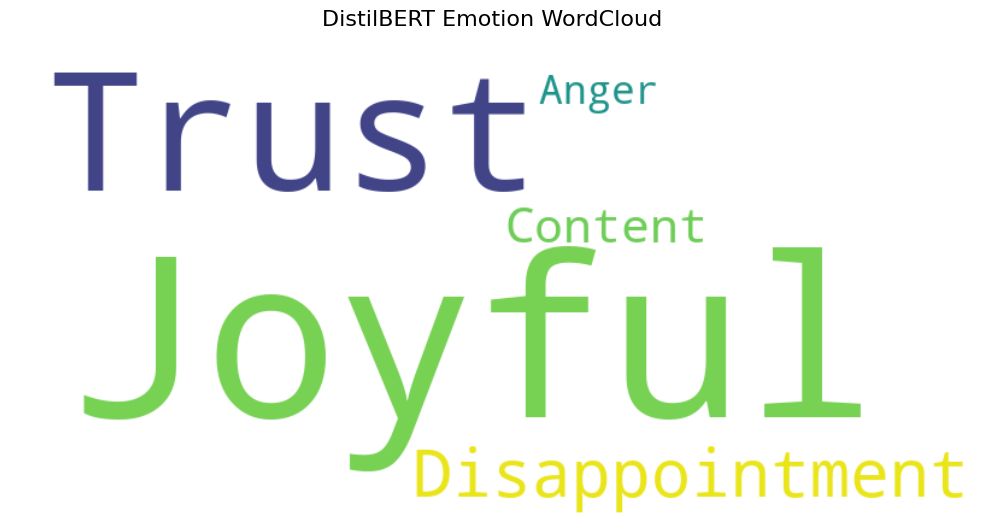

In [57]:
# Generate word cloud for DistilBERT
# Flatten the `emotion_labels` column to aggregate all emotions
all_emotions = [emotion for emotions in df['DistilBERT_emotion_labels'] for emotion in emotions]
emotion_counts = Counter(all_emotions)

# Generate the WordCloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis'
).generate_from_frequencies(emotion_counts)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('DistilBERT Emotion WordCloud', fontsize=16)
plt.tight_layout()
plt.show()

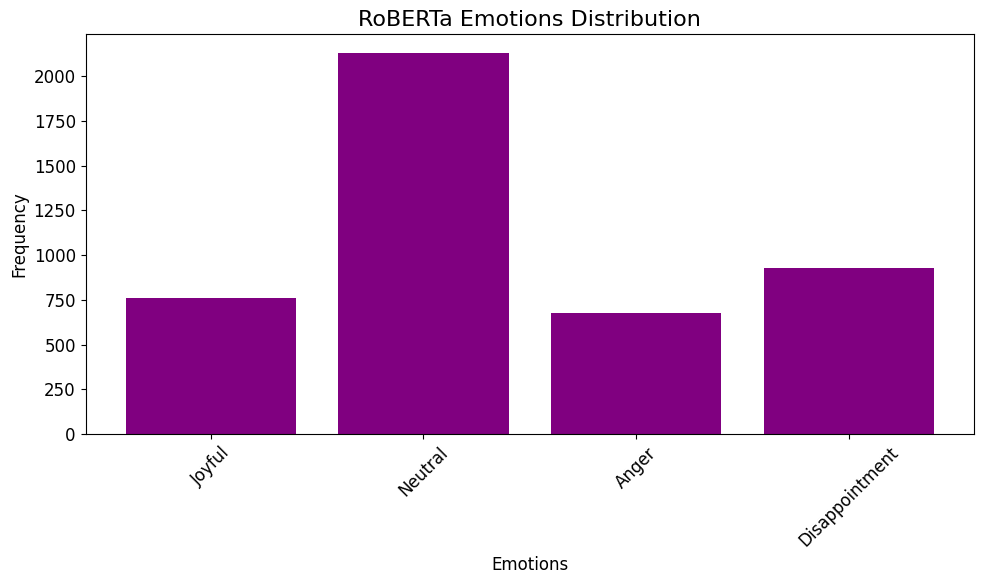

In [59]:
# Count the occurrences of each emotion
emotion_counts = df['RoBERTa_emotion'].value_counts()
polarity_counts = df['RoBERTa_polarity'].value_counts()

import matplotlib.pyplot as plt
from collections import Counter

# Flatten the `dominant_emotion` column to aggregate all emotions
all_emotions = [emotion for emotions in df['RoBERTa_emotion'] if isinstance(emotions, list) for emotion in emotions]
emotion_counts = Counter(all_emotions)

# Flatten the `dominant_polarity` column
all_polarities = df['RoBERTa_polarity']
polarity_counts = Counter(all_polarities)

# Bar chart for emotions
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='purple')
plt.title('RoBERTa Emotions Distribution', fontsize=16)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



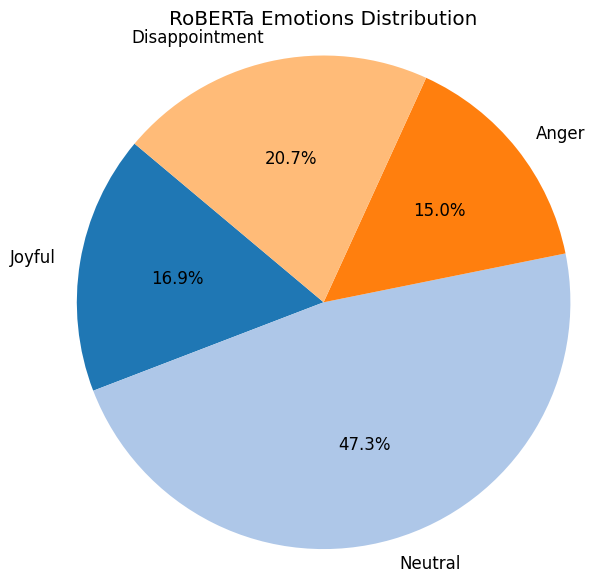

In [60]:
# Pie chart for emotions
plt.figure(figsize=(6, 6))
plt.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('RoBERTa Emotions Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()



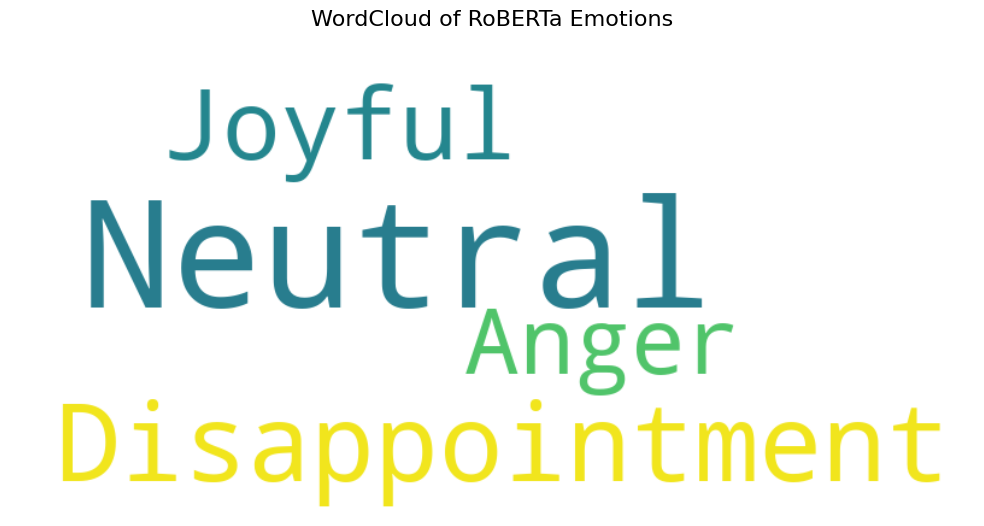

In [61]:
# Generate WordCloud for `dominant_emotion`

# WordCloud for emotions
emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(emotion_counts)

plt.figure(figsize=(10, 6))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('RoBERTa Emotions Word Cloud', fontsize=16)
plt.tight_layout()
plt.show()

